<a href="https://colab.research.google.com/github/sanamehrabbeigi/Deep-Learning-Course/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5: تولید موسیقی با استفاده از شبکه‌های عصبی بازگشتی
Welcome to Homework 5  &#128522;&#9996;

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div dir='rtl'style="text-align: right;font-family:verdana;">


ابتدا بسته‌ها و کتابخانه‌های مورد نیاز را import میکنیم، در طول اجرای کد هر پکیج دیگری که نیاز دارید، قرار دهید.

In [ ]:
!pip install -e /content/drive/MyDrive/colab/HW5/deeplearningcourse-20211226T165502Z-001/deeplearningcourse
import deeplearningcourse as dlc
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

Obtaining file:///content/drive/MyDrive/colab/HW5/deeplearningcourse-20211226T165502Z-001/deeplearningcourse
  Attempting uninstall: deeplearningcourse
    Found existing installation: deeplearningcourse 0.0.0
    Can't uninstall 'deeplearningcourse'. No files were found to uninstall.
  Running setup.py develop for deeplearningcourse




## A) مجموعه داده

<div dir='rtl'style="text-align: right;font-family:verdana;">

ابتدا دیتاست مورد نظر را از طریق پکیجی که در گوگل درایو قرار دایم، load کرده و مراحل بعدی را انجام می‌دهیم.
همانطور که گقتیم دیتاست مورد نظر تعدادی آهنگ محلی ایرلندی است که با نماد ABC نشان داده می‌شود. برای درک بهتر می‌توانیم یکی از این آهنگ‌ها را در نماد ABC نشان دهیم.
همچنین می‌توانیم این اهنگ را به صورت صوتی نمایش داده و پخش کنیم.





*  یکی از نکات مهمی که باید به آن توجه کنید این است که نماد موسیقی فقط شامل اطلاعاتی در مورد نت‌های در حال پخش نمی‌باشد بلکه علاوه بر این اطلاعات، اطلاعات دیگری مانند عنوان آهنگ، کلید و tempo آهنگ نیز وجود دارد.



In [ ]:

songs = dlc.P1.load_data()
examplesong = songs[25]
print(examplesong)



Found 817 songs in text
X:24
T:Flowers of Edinburgh
Z: id:dc-hornpipe-23
M:C|
L:1/8
K:G Major
GE|D2DE G2GA|BGBd cBAG|FGEF DEFG|A2FA D2GE|!
D2DE G2GA|BGBd efge|dcBA GFGA|B2G2 G2:|!
(3def|g2gf gbag|f2fe fagf|edef gfed|B2e2 e2ge|!
dBGB d2Bd|edef g2ge|dcBA GFGA|B2G2 G2:|


In [ ]:
joined_songs = "\n\n".join(songs)
vocab = sorted(set(joined_songs))
print( len(vocab))

83


<div dir='rtl'style="text-align: right;font-family:verdana;">


روند کار به این صورت است که دنباله‌ای از کاراکترها را به مدل وارد می‌کنیم و مدل را برای پیش‌بینی خروجی که کاراکتر بعدی در هر تایم زمانی است، آموزش می‌دهیم. مدل‌های RNN یک intenal state دارند که به عناصر دیده شده قبلی بستگی دارد، بنابراین اطلاعات مربوط به همه کاراکترهای دیده شده تا یک لحظه مشخص برای ایجاد پیش‌بینی گرفته می‌شوند.





###  A-1) تبدیل متن به بردار

<div dir='rtl'style="text-align: right;font-family:verdana;">



قبل از شروع آموزش مدل RNN باید یک نمایش عددی از مجوعه داده‌های متنی خود ایجاد کنیم. برای این کار می‌توانیم دو جدول مراجعه ایجاد کنیم که یکی از آنها کاراکترها را به عدد نگاشت می‌کند و دیگری اعداد را به کاراکتر برمی‌گراند. فعلا این کار را برای کاراکترهای منحصر به فرد در دیتاست انجام می‌دهیم.

همچنین می‌توانید این نمایش عددی را برای داده‌های متن مشاهده کنید:

In [ ]:

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [ ]:

for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:2d},'.format(repr(char), char2idx[char]))

  '\n':  0,
  ' ' :  1,
  '!' :  2,
  '"' :  3,
  '#' :  4,
  "'" :  5,
  '(' :  6,
  ')' :  7,
  ',' :  8,
  '-' :  9,
  '.' : 10,
  '/' : 11,
  '0' : 12,
  '1' : 13,
  '2' : 14,
  '3' : 15,
  '4' : 16,
  '5' : 17,
  '6' : 18,
  '7' : 19,


<div dir='rtl'style="text-align: right;font-family:verdana;">

**تمرین:**

تابعی بنویسید که همه songs string ها را به نمایش عددی تبدیل کند. توجه داشته باشید که خروجی این تابع باید یک np.array با N عنصر باشد که N تعداد کاراکترهای رشته ورودی است. خروجی تابع را vectorized_songs نامگذاری کنید و در مراحل بعدی استفاده کنید.

In [ ]:
 def vectorize(string):
   vectorized_songs = np.array([char2idx[char] for char in string])
   return vectorized_songs

  # ...


In [ ]:
vectorized_songs = vectorize(joined_songs)

<div dir='rtl'style="text-align: right;font-family:verdana;">


همچنین می‌توان نحوه نگاشت اولین قسمت متن را به یک نمایش integer نمایش داد.

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(joined_songs[:20]), vectorized_songs[:20]))

"X:1\nT:Alexander's\nZ:" ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79 56 69 59 60 73  5 74  0 51 22]




## B)  ایجاد نمونه‌های آموزش و لیبل‌ها

<div dir='rtl'style="text-align: right;font-family:verdana;">

گام بعدی این است که متن را به دنباله‌های نمونه‌ای که در طول آموزش از آن استفاده می‌کنیم، تبدیل کنیم. هر دنباله ورودی که به مدل RNN می‌دهیم دارای یک seq_length است، همچنین باید یک دنباله target برای هر ورودی تعریف کنیم که در آموزش RNN برای پیش‌بینی کاراکتر بعدی استفاده می‌شود.

مثلا اگر فرض کنیم seq_length برابر با چهار باشد و متن ورودی ما "Hello"  باشد، دنباله هدف "ello" است.



*   روش دسته‌ای به ما این امکان را می‌دهد که این جریان کاراکترها را به دنباله‌هایی با اندازه‌های دلخواه تبدیل کنیم.

*
تابع creat_examples نمونه‌های مورد نظر ما را ایجاد می‌کند و از آن برای تولید داده‌های آموزش و لیبل‌های آن‌ها استفاده می‌کنیم.

In [ ]:
#  creat training examples and targets

def creat_examples(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]


  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

<div dir='rtl'style="text-align: right;font-family:verdana;">


   برای درک بهتر می‌توانید چند کاراکتر اول در متن را به همراه target آن مشاهده کنید.




In [ ]:

x_batch, y_batch = creat_examples(vectorized_songs, seq_length= 5, batch_size= 1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 27 ('B')
  expected output: 14 ('2')
Step   1
  input: 14 ('2')
  expected output: 27 ('B')
Step   2
  input: 27 ('B')
  expected output: 26 ('A')
Step   3
  input: 26 ('A')
  expected output: 82 ('|')
Step   4
  input: 82 ('|')
  expected output: 27 ('B')




## C) شبکه‌های عصبی بازگشتی

### C-1) تعریف مدل

<div dir='rtl'style="text-align: right;font-family:verdana;">

پس از آماده‌سازی داده‌های آموزش و تست، می‌خواهیم یک شبکه عصبی بازگشتی طراحی کنیم، آموزش دهیم و سپس از مدل آموزش دیده برای تولید موسیقی جدید استفاده کنیم.

**تمرین:**

مدل پیشنهادی خود را ارائه کنید و آن را آموزش دهید:

In [ ]:
# Defining the RNN Model
# TODO
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
      rnn_units,
      return_sequences=True,
      recurrent_initializer='glorot_uniform',
      recurrent_activation='sigmoid',
      stateful=True,
      )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
                               LSTM(rnn_units),
                               tf.keras.layers.Dense(vocab_size)
                               ])
  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


<div dir='rtl'style="text-align: right;font-family:verdana;">

**تمرین:**

با در نظر گرفتن طول ورودی برابر با 100 و استفاده از تابع pred اندازه خروجی را نشان دهید:


*   
توجه داشته باشید که می‌توان مدل را بر روی ورودی‌هایی با هر اندازه آموزش داد.









In [ ]:
x, y = creat_examples(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")
# TODO

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


<div dir='rtl'style="text-align: right;font-family:verdana;">

همچنین می‌توانیم رمزگشایی انجام دهیم تا ورودی را با متن پیش‌بینی شده توسط مدل آموزش ندیده مقایسه کنیم:

In [ ]:
sampled_indices = tf.random.categorical(pred[10], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([71, 68, 75, 29, 40, 16, 13,  8, 77, 24, 66, 48, 41, 58, 58, 60, 64,
       36, 35, 77, 78, 34, 13, 65, 28, 81, 77, 79, 27, 41, 50, 16, 74, 43,
       18, 30,  5, 74, 56, 33, 40,  5, 59,  9, 48, 43, 73, 54, 31, 20, 17,
       13, 39,  0, 43,  7, 40, 21, 17,  1,  2, 62, 26, 66, 60, 57, 45, 69,
       47,  4, 68, 12, 60, 50, 34, 78, 22, 34, 11, 27, 63, 17, 19,  4, 21,
       37, 34, 33, 52,  1, 78, 37, 11, 48, 25, 40, 70, 67,  7, 64])

In [ ]:
print("input: \n", repr("".join(idx2char[x[10]])))
print("char prediction: \n", repr("".join(idx2char[sampled_indices])))

input: 
 'cAF FEF|c2d cga|!\nbgb afa|gfe d2B|cBc edc|dBG G2|]!\n\nX:100\nT:Mug of Brown Ale\nZ: id:dc-jig-81\nM:6/8\n'
char prediction: 
 "pmtDO41,v=kWPcceiKJvwI1jCzvxBPY4sR6E'saHO'd-WRr^F851N\nR)O95 !gAkebTnV#m0eYIw:I/Bh57#9LIH[ wL/W>Ool)i"


### C-2) آموزش مدل

<div dir='rtl'style="text-align: right;font-family:verdana;">



*   همانطور که مشاهده می‌کنیم متن تولید شده توسط مدل آموزش ندیده بسیار بی معنی است و باید برای بهبود مدل را آموزش دهیم.





**تمرین:**

تابع هزینه مناسب را برای محاسبه و برگرداندن خطا بین لیبل‌های واقعی و پیش‌بینی شده تعریف کنید.
 ( از تابع هزینه sparse_categorical_crossentropy  استفاده کنید.)

In [ ]:
# Defining the loss function
def loss_function(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

<div dir='rtl'style="text-align: right;font-family:verdana;">


**تمرین:**

تابع خطا را برای محاسبه و برگرداندن مقدار خطا بین مقدار واقعی و مقدار پیش‌بینی شده مدل آموزش ندیده اعمال کنید و مقدار خطا را نشان دهید:

In [ ]:
# TODO
example_batch_loss = loss_function(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.417786


<div dir='rtl'style="text-align: right;font-family:verdana;">


**تمرین:**

با تعریف هایپرپارامترها به صورت مناسب مدل را آموش دهید:



-    هایپرپارامترهای مناسب را برای شبکه انتخاب کرده و نحوه به دست آوردن این هایپرپارامترها را توضیح دهید.
num_training_iterations =

 هر چه بیشتر شود مدت زمان آموزش بیشتر می شود

batch_size =

عددی بین 1 تا 64 که برای سادگی کار ما 1 را انتخاب کرده ایم

seq_length =

عددی بین 50 تا 500 که با آزمون و خطا 100 را انتخاب کردیم

learning_rate =

 را با آزمون و خطا انتخاب کرده ایم.5e-3که 1e-5 و 1e-1 عددی بین

-  بعد از تعریف هایپرپارامترها مدل را آموزش داده و دقت آن را روی داده‌های آموزش گزارش دهید. همچنین نمودار خطا را در طی فرایند آموزش رسم کنید.

-    تعداد ایپوک‌ها در مرحله آموزش چگونه بر عملکرد مدل تاثیر می‌گذارند؟

    هر چه بیشتر شوند طول مدت آموزش بیشتر می شود ولی باید مواظب باشیم که دچار
  overfitting نشویم زیرا آموزش بیش از حد  باعث بالا بودن واریانس می شود.



In [ ]:
### Hyperparameter setting and optimization ###
num_training_iterations = 2000
batch_size = 1
seq_length = 100
learning_rate = 5e-3

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

optimizer = tf.keras.optimizers.Adam(learning_rate)

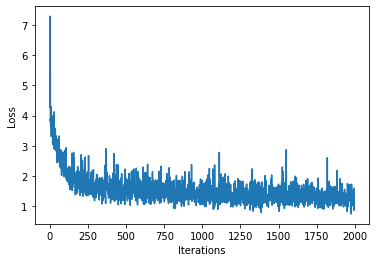

100%|██████████| 2000/2000 [01:42<00:00, 19.44it/s]


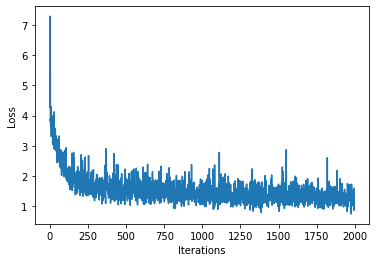

In [ ]:
### train model
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = loss_function(y, y_hat)
  grads = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

# training

history = []
plotter = dlc.P4.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm(range(num_training_iterations)):
  x_batch, y_batch = creat_examples(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  history.append(loss.numpy().mean())
  plotter.plot(history)

  #if iter % 100 == 0:
    #model.save_weights(checkpoint_prefix)

model.save_weights(checkpoint_prefix)



## D) تولید موسیقی با استفاده از شبکه‌های عصبی بازگشتی

<div dir='rtl'style="text-align: right;font-family:verdana;">

اکنون می‌توانیم از RNN آموزش دیده برای تولید موسیقی استفاده کنیم. هنگام تولید موسیقی، ما باید مدل را به نوعی تغذیه کنیم تا شروع به کار کند. هنگامی که یک seed تولید شده داریم، می‌توانیم هر یک از کاراکترهای پی در پی را به صورت تکراری پیش‌بینی کنیم.




*   به این نکته توجه داشته باشید که مدل RNN از یک لایه softmax  در لایه آخر استفاده می‌کند که برای نتیجه‌گیری به طور مکرر از این توزیع‌ها نمونه می‌گیریم و سپس از نمونه‌های خود برای کدگذاری آهنگ تولید شده قالب ABC استفاده می‌کنیم.

**تمرین:**

تابع زیر را برای تولید موسیقی با استفاده از مدل آموزش دیده خود تمکیل کنید:


In [ ]:

def text_generation(model, start_string, generation_length=1000):
# TODO
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)

      predictions = tf.squeeze(predictions, 0)

      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

<div dir='rtl'style="text-align: right;font-family:verdana;">


**تمرین:**

اکنون می‌توانید موسیقی‌های تولید شده (text)
را به صورت زیر یا به هر طریقی که می‌توانید، در قالب ABC نشان داده یا پخش کنید.

In [ ]:
text = text_generation(model, start_string="X", generation_length=1000)

songs = dlc.P1.extract_songsnippet(text)
for i, song in enumerate(songs):
  dlc.P1.play(song)
  print(song, end="\n\n\n\n")

100%|██████████| 1000/1000 [00:09<00:00, 100.57it/s]


Found 5 songs in text
X:100
T:Mad ermagh Is iw
Z: id:dc-reel-118
M:C
L:1/8
K:G Major
Bgg2 ageA|c2ec cece|fgag edgb|a2gf ged:|!



X:19
T:Mullackoll ellughan's
Z: id:dc-reel-224
M:C
L:1/8
K:D Major
zE|B,DEE DAFA|DEGF EFGB|A3A BGEA|]!
BAA2 fagA|BcdB A2Bd|cBAG EGAF|!
DEA2 G26K:D Major
gag agea|g2aA edgd|BcBe defg|fgag edgf|edcA GADE|!
[1 feaf gedB|GFGA Bcde|fafe dcBA|GBde fdec|d2gd BGAB|EGBG EEEG|FDD2 FEDE|FGcG G2:|!
d|cde2 dBA|G2E GEE|Bde ce|Aec d2A|fga ged|!
Add ed^c|dfa gca|ea ab|ag/f/e/|d/c/f/e/ id:|!



X:21
T:Kosrerlesell Willy
Z: id:dc-reel-134
M:C
L:1/8
K:D Major
dgg2 dgd^c|d2B G2:|!



X:150
T:Crown Blerlavaitea
Z: id:dc-polka-17
M:3/4
L:1/8
K:E Mixolydian
ge3 ceAc|edBc ABcA|G2GF G:|!
aga2 baag|edgd edgd|eaa^g abag|!
fdd2 edec|dgg2 d2Bd|gfge ageg|bagf e2:|!
agg2 dgdg|fdd2 cAeA|ABBA ceA2|cBc2 A2eA|fdec ABde|fage fdAF|GBBA d2AB:|!



X:105
T:Carlivdarhaipeipatt
Z: id:3
T:Cro2s Is Tagsgin
Z: id:dc-reel-90
M:9/8
L:4/8
K: G3B|c2Ac BGG:|!
Bc|dBAF ABGA|FAAG AcBA|!
[1 g2eg fAec|dFAB cAGF